In [ ]:
! pip install datasets transformers huggingface_hub
! pip install transformers torch pandas

import numpy as np
import pandas as pd
import os
import json
import torch

! pip install tqdm
from tqdm import tqdm

from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from sklearn.metrics import classification_report

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## DISTILBERT MODEL

In [3]:
def load_and_preprocess_yelp_reviews(file_path):
    reviews = pd.read_csv(file_path, encoding='latin1')
    reviews_sample = reviews.sample(frac=0.05, random_state=42).reset_index(drop=True)

    # Print the number of data points sampled
    print(f"Number of data points sampled: {len(reviews_sample)}")

    return reviews_sample

# Load and preprocess Yelp reviews
yelp_reviews = load_and_preprocess_yelp_reviews('../data/yelp reviews.csv')


<ipython-input-3-c818eba3f572>:2: DtypeWarning: Columns (0,9,10,11,12,13,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  reviews = pd.read_csv(file_path, encoding='latin1')


Number of data points sampled: 52429


In [4]:
class YelpReviewDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels.iloc[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.labels)


In [5]:
def rating_to_sentiment(rating):
    if rating <= 2:
        return 0  # Negative
    elif rating == 3:
        return 1  # Neutral
    else:
        return 2  # Positive

In [6]:
labels = yelp_reviews['Raitng'].apply(rating_to_sentiment)

In [7]:
#Load Lexicon Dictionaries

def load_lexicons(lexicon_file_paths):
    lexicons = {}
    for file_path in lexicon_file_paths:
        lexicon_name = file_path.split('/')[-1].split('.')[0]
        lexicons[lexicon_name] = pd.read_csv(file_path)
    return lexicons

lexicon_files = ['../data/yelp_lexicons/ambience.csv',
'../data/yelp_lexicons/cuisine.csv',
'../data/yelp_lexicons/food.csv',
'../data/yelp_lexicons/price.csv',
'../data/yelp_lexicons/restaurant.csv',
'../data/yelp_lexicons/service.csv',
'../data/yelp_lexicons/staff.csv'
]
lexicons = load_lexicons(lexicon_files)

assert len(labels) == len(yelp_reviews)

In [8]:
#DistilBERT Model SETUP
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')

def rating_to_sentiment(rating):
    if rating <= 2:
        return 0  # Negative
    elif rating == 3:
        return 1  # Neutral
    else:
        return 2  # Positive

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias', 'pre_classifier.weight', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
from sklearn.model_selection import train_test_split

# Split the dataset into training, validation, and testing sets first
train_data, temp_data = train_test_split(yelp_reviews, test_size=0.3, random_state=42)
validation_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

train_data.reset_index(drop=True, inplace=True)
validation_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)

#function to tokenize a list of reviews
def tokenize_reviews(reviews, tokenizer):
    tokenized_reviews = {'input_ids': [], 'attention_mask': []}

    for review in tqdm(reviews, desc="Tokenizing reviews"):
        encoded_review = tokenizer.encode_plus(
            review,
            max_length=512,
            truncation=True,
            padding='max_length',
            return_tensors="pt"
        )
        tokenized_reviews['input_ids'].append(encoded_review['input_ids'][0])
        tokenized_reviews['attention_mask'].append(encoded_review['attention_mask'][0])

    # Convert lists of tensors to a single tensor
    tokenized_reviews['input_ids'] = torch.stack(tokenized_reviews['input_ids'])
    tokenized_reviews['attention_mask'] = torch.stack(tokenized_reviews['attention_mask'])

    return tokenized_reviews

# Tokenize each dataset
train_encodings = tokenize_reviews(list(train_data['Comment']), tokenizer)
val_encodings = tokenize_reviews(list(validation_data['Comment']), tokenizer)
test_encodings = tokenize_reviews(list(test_data['Comment']), tokenizer)

# Convert ratings to sentiment labels
train_labels = train_data['Raitng'].apply(rating_to_sentiment)
val_labels = validation_data['Raitng'].apply(rating_to_sentiment)
test_labels = test_data['Raitng'].apply(rating_to_sentiment)

# Create datasets for each split
train_dataset = YelpReviewDataset(train_encodings, train_labels)
val_dataset = YelpReviewDataset(val_encodings, val_labels)
test_dataset = YelpReviewDataset(test_encodings, test_labels)

# DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)


Tokenizing reviews: 100%|██████████| 7865/7865 [00:24<00:00, 316.05it/s]


In [10]:
# Ensure CUDA (GPU support) is available or else use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Model and Optimizer
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=3)
model.to(device)
optimizer = AdamW(model.parameters(), lr=5e-5)

# Training Loop
train_losses = []
val_losses = []
num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{num_epochs} [Training]")
    for batch in progress_bar:
        # Move input and labels to the device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Zero the gradients on the model
        optimizer.zero_grad()

        # Forward pass
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        # Backward pass
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        progress_bar.set_postfix({'train_loss': loss.item()})

    avg_train_loss = total_train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    total_val_loss = 0
    progress_bar = tqdm(val_dataloader, desc=f"Epoch {epoch + 1}/{num_epochs} [Validation]")
    with torch.no_grad():
        for batch in progress_bar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss

            total_val_loss += loss.item()
            progress_bar.set_postfix({'val_loss': loss.item()})

    avg_val_loss = total_val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} - Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias', 'pre_classifier.weight', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/20 [Validation]: 100%|██████████| 246/246 [00:36<00:00,  6.66it/s, val_loss=0.382]


Epoch 1/20 - Training Loss: 0.4098, Validation Loss: 0.3487


Epoch 2/20 [Validation]: 100%|██████████| 246/246 [00:36<00:00,  6.66it/s, val_loss=0.315]


Epoch 2/20 - Training Loss: 0.2923, Validation Loss: 0.3633


Epoch 3/20 [Validation]: 100%|██████████| 246/246 [00:36<00:00,  6.67it/s, val_loss=0.404]


Epoch 3/20 - Training Loss: 0.2103, Validation Loss: 0.3939


Epoch 4/20 [Validation]: 100%|██████████| 246/246 [00:36<00:00,  6.66it/s, val_loss=0.411]


Epoch 4/20 - Training Loss: 0.1386, Validation Loss: 0.4691


Epoch 5/20 [Validation]: 100%|██████████| 246/246 [00:36<00:00,  6.66it/s, val_loss=0.636]


Epoch 5/20 - Training Loss: 0.0923, Validation Loss: 0.5404


Epoch 6/20 [Validation]: 100%|██████████| 246/246 [00:36<00:00,  6.67it/s, val_loss=0.324]


Epoch 6/20 - Training Loss: 0.0689, Validation Loss: 0.6213


Epoch 7/20 [Validation]: 100%|██████████| 246/246 [00:36<00:00,  6.67it/s, val_loss=0.434]


Epoch 7/20 - Training Loss: 0.0513, Validation Loss: 0.5930


Epoch 8/20 [Validation]: 100%|██████████| 246/246 [00:37<00:00,  6.64it/s, val_loss=0.676]


Epoch 8/20 - Training Loss: 0.0447, Validation Loss: 0.6648


Epoch 9/20 [Validation]: 100%|██████████| 246/246 [00:36<00:00,  6.66it/s, val_loss=0.773]


Epoch 9/20 - Training Loss: 0.0367, Validation Loss: 0.6650


Epoch 10/20 [Validation]: 100%|██████████| 246/246 [00:37<00:00,  6.65it/s, val_loss=0.564]


Epoch 10/20 - Training Loss: 0.0352, Validation Loss: 0.7364


Epoch 11/20 [Validation]: 100%|██████████| 246/246 [00:36<00:00,  6.65it/s, val_loss=1.06]


Epoch 11/20 - Training Loss: 0.0309, Validation Loss: 0.8151


Epoch 12/20 [Validation]: 100%|██████████| 246/246 [00:36<00:00,  6.67it/s, val_loss=0.993]


Epoch 12/20 - Training Loss: 0.0278, Validation Loss: 0.8286


Epoch 13/20 [Validation]: 100%|██████████| 246/246 [00:36<00:00,  6.67it/s, val_loss=0.859]


Epoch 13/20 - Training Loss: 0.0263, Validation Loss: 0.9050


Epoch 14/20 [Validation]: 100%|██████████| 246/246 [00:36<00:00,  6.68it/s, val_loss=0.632]


Epoch 14/20 - Training Loss: 0.0230, Validation Loss: 0.7852


Epoch 15/20 [Validation]: 100%|██████████| 246/246 [00:36<00:00,  6.67it/s, val_loss=0.742]


Epoch 15/20 - Training Loss: 0.0235, Validation Loss: 0.7806


Epoch 16/20 [Validation]: 100%|██████████| 246/246 [00:36<00:00,  6.68it/s, val_loss=1.01]


Epoch 16/20 - Training Loss: 0.0230, Validation Loss: 0.8615


Epoch 17/20 [Validation]: 100%|██████████| 246/246 [00:36<00:00,  6.66it/s, val_loss=0.592]


Epoch 17/20 - Training Loss: 0.0208, Validation Loss: 0.8130


Epoch 18/20 [Validation]: 100%|██████████| 246/246 [00:36<00:00,  6.67it/s, val_loss=0.58]


Epoch 18/20 - Training Loss: 0.0210, Validation Loss: 0.8250


Epoch 19/20 [Validation]: 100%|██████████| 246/246 [00:36<00:00,  6.66it/s, val_loss=0.698]


Epoch 19/20 - Training Loss: 0.0194, Validation Loss: 0.7943


Epoch 20/20 [Validation]: 100%|██████████| 246/246 [00:36<00:00,  6.68it/s, val_loss=0.448]

Epoch 20/20 - Training Loss: 0.0173, Validation Loss: 0.9377


In [52]:
model.eval()
all_predictions = []
all_true_labels = []

with torch.no_grad():
    for batch in test_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)

        all_predictions.extend(predictions.cpu().numpy())
        all_true_labels.extend(labels.cpu().numpy())

# Calculate and print the classification report
from sklearn.metrics import classification_report, accuracy_score
print(classification_report(all_true_labels, all_predictions, target_names=['Negative', 'Neutral', 'Positive']))
# Print overall accuracy
overall_accuracy = accuracy_score(all_true_labels, all_predictions)
print(f"Overall Accuracy: {overall_accuracy:.2f}")

              precision    recall  f1-score   support

    Negative       0.73      0.92      0.81      1438
     Neutral       0.60      0.34      0.43      1232
    Positive       0.91      0.94      0.92      5195

    accuracy                           0.84      7865
   macro avg       0.74      0.73      0.72      7865
weighted avg       0.83      0.84      0.83      7865

Overall Accuracy: 0.84


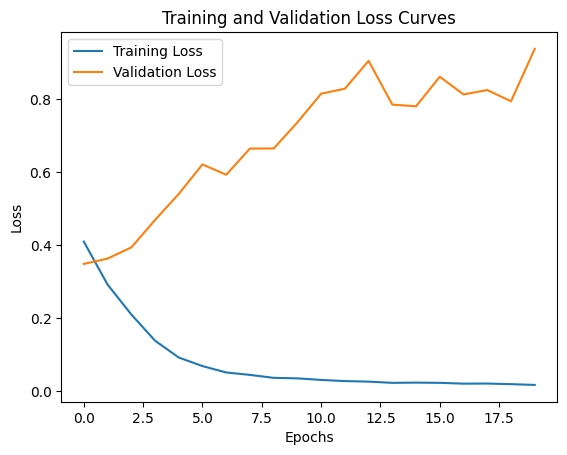

In [13]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.show()

In [49]:
# Save the model's state dictionary
model_save_path = '../saved_models/distilBERT_parameters.pth'
torch.save(model.state_dict(), model_save_path)

print(f"Model saved to {model_save_path}")

# loading the model
# model.load_state_dict(torch.load('/content/gdrive/MyDrive/model_state.pth'))


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Model saved to /content/gdrive/MyDrive/SYSEN 6888/Code/distilBERT_parameters.pth


In [35]:
# Load the dataset
yelp_reviews = pd.read_csv("../data/yelp reviews.csv", encoding='latin1')

# Remove NaN reviews
drop_indices = yelp_reviews[yelp_reviews['Comment'].map(type) != str].index.tolist()
yelp_reviews = yelp_reviews.drop(drop_indices).reset_index(drop=True)

# Now, apply the length calculation
yelp_reviews['Length'] = yelp_reviews['Comment'].apply(lambda x: len(x.split()))

# Keep only 'Length' and 'Comment' columns
yelp_reviews = yelp_reviews[['Length', 'Comment']]


<ipython-input-35-b167ce823e5f>:2: DtypeWarning: Columns (0,9,10,11,12,13,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  yelp_reviews = pd.read_csv("/content/gdrive/MyDrive/SYSEN 6888/Code/yelp_dataset/yelp reviews.csv", encoding='latin1')


In [44]:
# Specified indices
index = [44823, 62302, 82119, 183012, 317114, 320417, 324000, 335281, 341490, 404605, 457119, 478264, 488909, 532973]

# Validate indices - making sure they are within the new DataFrame's range
valid_indices = [idx for idx in index if idx < len(yelp_reviews)]

# Access reviews by valid indices
new_reviews = [(i, yelp_reviews.iloc[i]['Comment']) for i in valid_indices]

print(f"Number of reviews to analyze: {len(new_reviews)}")


Number of reviews to analyze: 14


In [45]:
# Iterate over each review in new_reviews
for original_idx, review in new_reviews:
    # Encode the review
    encoded_review = tokenizer.encode_plus(review, max_length=512, truncation=True, padding='max_length', return_tensors="pt")

    # Move encoded review to the correct device
    input_ids = encoded_review['input_ids'].to(device)
    attention_mask = encoded_review['attention_mask'].to(device)

    # Perform sentiment analysis
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        prediction = torch.argmax(outputs.logits, dim=-1)

    # Determine sentiment
    sentiment = ['Negative', 'Neutral', 'Positive'][prediction.item()]
    print(f"Original Review Index: {original_idx}\nReview: \"{review}...\"\nSentiment: {sentiment}\n")


Original Review Index: 44823
Review: "My roommates and I got a large pie which took an hour to get to us (pretty reasonable), but wowie wow was the pizza a disappointment. Undercooked/mushy in the middle with bland sauce and very few redeeming factors. I could've saved my $$ and bought a frozen pizza at the store- it certainly would've tasted better...."
Sentiment: Negative

Original Review Index: 62302
Review: "I eat here almost every single weekend. The worst the food has ever been is "Eh, average" and I think that's usually just when they've got like ten thousand deliveries and there's not a whole lot they can do about that, it kind of just is what it is. 98% of the time the food is SO GOOD. The portions seem to be larger when you eat in the restaurant, but they're not stingy ever by any means. I always have leftovers. The French fries are my favorite in the neighborhood, definitely order the hummus, and obviously the chicken gyro is delicious. I also regularly get the falafel and t